In [1]:
from src.filehandler import DataHandler
from src.regressor import Regressor, r_square, rmse
from stop_words import get_stop_words
import src.utils as utils

Using TensorFlow backend.


# Crear descriptores para los test A, B y C

In [2]:
stop_words = get_stop_words('spanish')
data_A = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
data_B = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_B_data")
data_C = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_C_data")
#usamos el metodo get data para obtener el X_test de largo 5000 para cada vectorizer mencionado en las regresiones
#test para Count-vectorizer con ngram_range = (1,1) y sin stop_words
X_test_A_1= data_A.get_data(method="count-vectorizer", stop_words=None, ngram_range=(1,1))[1]
print("X_test_A:", X_test_A_1.shape)
X_test_B_1= data_B.get_data(method="count-vectorizer", stop_words=None, ngram_range=(1,1))[1]
print("X_test_B:", X_test_B_1.shape)
X_test_C_1= data_C.get_data(method="count-vectorizer", stop_words=None, ngram_range=(1,1))[1]
print("X_test_C:", X_test_C_1.shape)

leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_A_data//test_A_images_names.txt
leyendo ./data/test_A_data//test_A_images_vectors.bin
1000 vectores de largo 2048
doing vectorization with CountVectorizer
fitting ...done
getting vectors transforms ...done
X_test_A: (5000, 573)
leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_B_data//test_B_images_names.txt
leyendo ./data/test_B_data//test_B_images_vectors.bin
1000 vectores de largo 2048
doing vectorization with CountVectorizer
fitting ...done
getting vectors transforms ...done
X_test_B: (5000, 573)
leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_C_data//test_C_images_names.txt
leyendo ./data/test_C_data//test_C_images_vectors.bin
1000 vector

# Leer Data

In [ ]:
#stop_words = get_stop_words('spanish')
#data = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
#X_train, X_test, y_train, y_test = data.get_data_count_vectorizer()
#X_train, X_test, y_train, y_test = data.get_data(method="tf-idf", stop_words=stop_words, ngram_range=(1,1))
#print("shapes")
#print("X_train:", X_train.shape)
#print("y_train:", y_train.shape)
#print("X_test:", X_test.shape)
#print("y_test:", y_test.shape)

# Cargar modelo

In [3]:
reg1 = Regressor()
reg1.load("cv_ngram11_none", custom_objects={"rmse": rmse, "r_square": r_square})

loading model from disk ... done!


{'val_loss': [0.5517921257019043,
  0.5269154042005539,
  0.5195567283034325,
  0.5156024369597435,
  0.5135611605644226,
  0.5112409794330597,
  0.5098605799674988,
  0.509106334745884,
  0.508329658806324,
  0.5079494023323059,
  0.5070360377430916,
  0.50715715020895,
  0.5068370795249939,
  0.5065619432926178,
  0.5063032013177872],
 'val_mean_absolute_error': [0.45499359905719755,
  0.4475104504823685,
  0.43855724155902864,
  0.43479357719421385,
  0.43303067952394486,
  0.43176506042480467,
  0.4363171660900116,
  0.43611047804355624,
  0.43877775222063065,
  0.4310839667916298,
  0.4360451325774193,
  0.4309844267368317,
  0.4338907879590988,
  0.43824971675872804,
  0.43368701249361036],
 'val_rmse': [0.7308616554737091,
  0.7128676426410675,
  0.7073274803161621,
  0.7043778687715531,
  0.702880722284317,
  0.7012471503019333,
  0.7004494577646255,
  0.699929975271225,
  0.6995401698350906,
  0.6989316362142562,
  0.6985502833127976,
  0.6984155982732773,
  0.6983737176656724

# Calcular indicadores

In [4]:
vectores_1A = reg1.predict(X_test_A_1)
vectores_1B = reg1.predict(X_test_B_1)
vectores_1C = reg1.predict(X_test_C_1)
#este se puede hacer una vez y listo
y_simple_test_A = data_A.load_simple_test("A")
y_simple_test_B = data_B.load_simple_test("B")
y_simple_test_C = data_C.load_simple_test("C")

leyendo ./data/test_A_data/test_A_images_names.txt
leyendo ./data/test_A_data/test_A_images_vectors.bin
1000 vectores de largo 2048
leyendo ./data/test_B_data/test_B_images_names.txt
leyendo ./data/test_B_data/test_B_images_vectors.bin
1000 vectores de largo 2048
leyendo ./data/test_C_data/test_C_images_names.txt
leyendo ./data/test_C_data/test_C_images_vectors.bin
1000 vectores de largo 2048


In [7]:
len(vectores_1C)

5000

In [8]:
from src.indicators import Indicators
ind = Indicators()

In [10]:
rank_1A = ind.similarity_search(y_simple_test_A, vectores_1A)
datos_1A = ind.get_formated_data()

initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 478 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 553 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 713 tasks      | 

done! (elapse time: 188.91 secs.)
getting sorted ranking ...done! (elapse time: 0.05 secs.)
done!


In [11]:
rank_1B = ind.similarity_search(y_simple_test_B, vectores_1B)
datos_1B = ind.get_formated_data()

initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 478 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 553 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 713 tasks      | 

done! (elapse time: 195.09 secs.)
getting sorted ranking ...done! (elapse time: 0.06 secs.)
done!


In [13]:
rank_1C = ind.similarity_search(y_simple_test_C, vectores_1C)
datos_1C = ind.get_formated_data()

initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 478 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 553 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 713 tasks      | 

done! (elapse time: 187.87 secs.)
getting sorted ranking ...done! (elapse time: 0.06 secs.)
done!


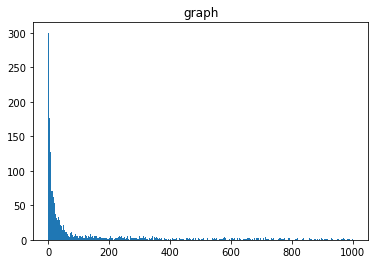

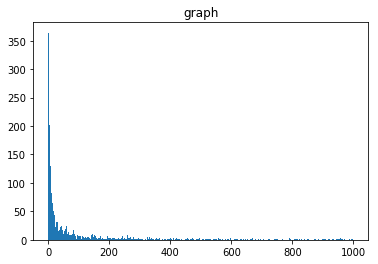

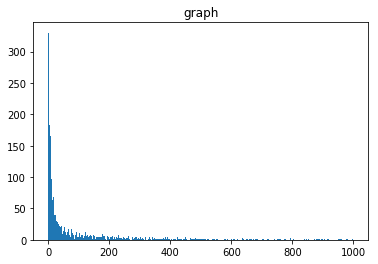

In [14]:
labels = ['recall@1','recall@5','recall@10','MRR','Mean']
test_names = ['Test_A', 'Test_B','Test_C']
datos = [datos_1A, datos_1B, datos_1C]
tabla = utils.get_table(datos, test_names, labels)
utils.print_histo(rank_1A)
utils.print_histo(rank_1B)
utils.print_histo(rank_1C)

In [15]:
tabla

,recall@1,recall@5,recall@10,MRR,Mean
Test_A,0.0600,0.2192,0.3416,0.147287,123.0536
Test_B,0.0728,0.2310,0.3458,0.155580,125.6716
Test_C,0.0660,0.2264,0.3538,0.153387,113.2210
